# **Group 8 Project - User Knowledge Modeling Data Set**
Authors: Minting Fu, Zeti Batrisha Jamiluddin Amini, Liz Ji, Caroline Zhang

## Introduction

In this project, we will study a dataset of 403 real user knowledge status in the area of Electrical DC Machines to understand how the user knowledge level is determined. Good academic performances are pursued both by students and educational institutions. In order to find a more efficient way to study and gain better academic scores, we need to further explore and analyze the User Knowledge dataset, which can be found <a href = "https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling" target = "_blank">here</a>.

We would like to investigate this question through our project:

* Is there a relationship between STG, SCG, STR, LPR, PEG and UNS? (ie. Which of STG, SCG, STR, LPR, PEG are contributing factors to UNS and how can we predict UNS better?)

We will be looking at 5 different variables to predict the knowledge level of users (UNS). These variables are:

* STG : the degree of study time for goal object materails.
* SCG : the degree of repetition number of user for goal object materails.
* STR : the degree of study time of user for related objects with goal object.
* LPR : the exam performance of user for related objects with goal object.
* PEG : the exam performance of user for goal objects.

## Methods

The first thing we do is to import the pacakges we are going to use for the entire project.

In [46]:
library(readxl)
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

In [47]:
#Using the set.seed function to make sure our code is reproducible
set.seed(7)

We will download and read the dataset. Since the dataset has been seperated into training and testing data ahead, we will read two datasets seperatedly as `training_data` and `testing_data`. 

In [48]:
# download the file from the website
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls'
download.file(url, destfile='data/user_knowledge_data.xls')

# read the dataset
training_data <- read_excel('data/user_knowledge_data.xls', sheet=2, range='A1:F259')           
print("Training Data")
training_data

testing_data <- read_excel('data/user_knowledge_data.xls', sheet=3, range='A1:F146')
print("Testing Data")
testing_data

[1] "Training Data"


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


[1] "Testing Data"


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


As we can see from the two datasets above, they are almost clean. We only need to change the data type of the UNS variable to factor so that it's more convenient for our further prediction. And another thing we will do is to unite UNS values into the same format of both training and testing dataset. We will also test whether there are missing data in two datasets.

In [54]:
# clean the training and testing data, and making sure that the target variable, UNS, is a factor type
training_data <- mutate(training_data, UNS = as_factor(UNS))
testing_data <- mutate(testing_data, UNS = as_factor(UNS))

# unite value format
training_data$UNS = tolower(training_data$UNS)
training_data <- training_data %>%
                 mutate(UNS = as_factor(UNS))
training_data

testing_data$UNS = tolower(testing_data$UNS)
testing_data <- testing_data %>%
    mutate(UNS = str_replace(UNS, " ", "_")) %>%
    mutate(UNS = as_factor(UNS))
testing_data

# test missing values

sprintf("The number of missing data in training data: %s", sum(is.na(training_data)))
sprintf("The number of missing data in testing data: %s", sum(is.na(testing_data)))

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,high
0.50,0.75,0.81,0.61,0.26,middle
0.66,0.90,0.76,0.87,0.74,high


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,very_low
0.05,0.05,0.55,0.60,0.14,low
0.08,0.18,0.63,0.60,0.85,high
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,low
0.66,0.68,0.81,0.57,0.57,middle
0.68,0.64,0.79,0.97,0.24,middle


[1] "The number of missing data in training data: 0"

[1] "The number of missing data in testing data: 0"

There are no missing values in our training and testing datasets.

**And now We can see from each table above:**

    1. each row is a single observation
    2. each column is a single variable 
    3. each value is a single cell
**Therefore, the training set and testing set are clean and tidy now.**

**We also notice that `the proportion of the training_data is around 64%`, and `the proportion of the test data is around 36%` from calculation.**

### Summarization

Now we are going to summarize the training dataset information.

In [50]:
# summarise the maximum value of each predictors
training_data_max <- training_data %>%
                     select(-UNS) %>%
                     map_df(max)
print("The maximum value of each predictors")
training_data_max

# summarise the minimum value of each predictors
training_data_min <- training_data %>%
                     select(-UNS) %>%
                     map_df(min)
print("The minimum value of each predictors")
training_data_min

# summarise the average value of each predictors
training_data_avg <- training_data %>%
                     select(-UNS) %>%
                     map_df(mean)
print("The average value of each predictors")
training_data_avg

[1] "The maximum value of each predictors"


STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.99,0.9,0.95,0.99,0.93


[1] "The minimum value of each predictors"


STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0


[1] "The average value of each predictors"


STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.4327132,0.4585388


**According to the tables above, we can see the range of each variable is :**
* The range of STG, the degree of study time for goal object materails, is [0, 0.99].
* The range of SCG, the degree of repetition number of user for goal object materails, is [0, 0.9].
* The range of STR, the degree of study time of user for related objects with goal object, is [0, 0.95].
* The range of LPR, the exam performance of user for related objects with goal object, is [0, 0.99].
* The range of PEG, the exam performance of user for goal objects, is [0, 0.93].

**Now, we have some basic ideas about our dataset. In the next step, We want to know which factor(s) is related to our target variable (UNS), in other words, which factor is our explanatory variable. To do this, we need to visualize our data to find out if there is a relationship between STG, SCG, STR, LPR, PEG and UNS.**

### Data Visualization
To visualize the data, we will use the `ggpairs` function, which returns a matrix of plots for a given dataset. Since we have 5 potential explanatory variables and 1 target variable, it is better to compare the distibution and evaluate the association of them in a whole. The `ggpairs` function provides an efficient way to exploring the distribution and correlation between different quantitative variables and categorical variables.

The `columns` argument is used to select the number of columns we want to include in the plot. In this case, we need to put `1:5` here since we have 5 prediction variables in total. 

We also need to change the font size of correlation values in order to make it fit in the panel and readable. To change the font size, we need to include `upper = list(continuous = wrap('cor', size = ...)` in our `ggpairs` function.

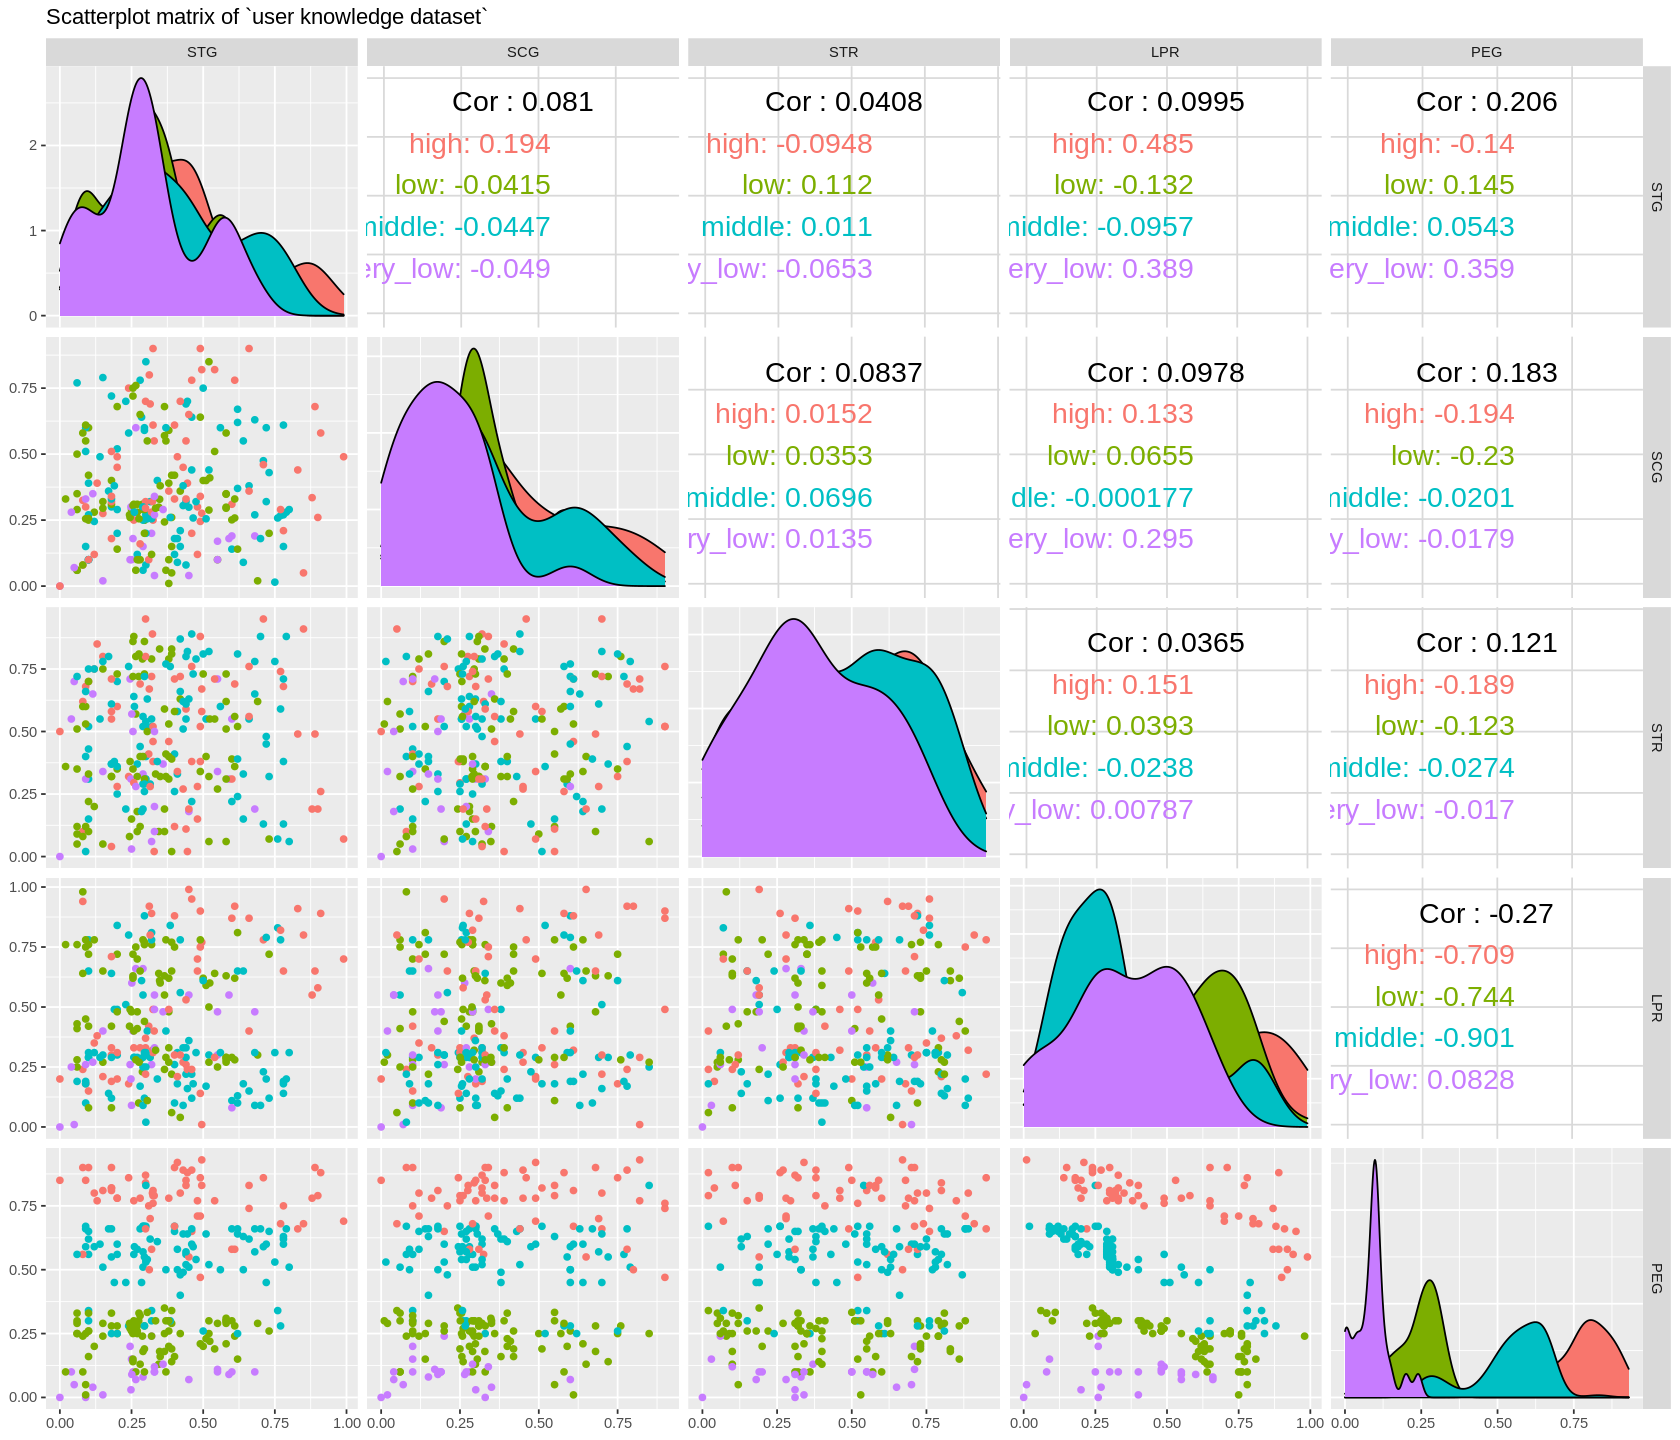

In [51]:
options(repr.plot.width = 14, repr.plot.height = 12)
relationship_plot <- ggpairs(training_data, columns = 1:5, 
                             ggplot2 :: aes(color = UNS), 
                             upper = list(continuous = wrap('cor', size = 6)), 
                             title = "Scatterplot matrix of `user knowledge dataset`")
relationship_plot

**By default, the upper panel shows the `correlation` between quantitative variables. The diagnal shows the `density plot` of quantitative variables. The lower panel shows the `scatterplot` and `histogram` of quantitative variables. The right-hand sides shows the `side-by-side boxplot` between quantitative and categorical variables and `bar chart` of the categorical variable.**

**Recall from previous information, we have 6 variables in this user knowledge dataset, they are:**

* STG : the degree of study time for goal object materails. (Quantitative variable)
* SCG : the degree of repetition number of user for goal object materails. (Quantitative variable)
* STR : the degree of study time of user for related objects with goal object. (Quantitative variable)
* LPR : the exam performance of user for related objects with goal object. (Quantitative variable)
* PEG : the exam performance of user for goal objects. (Quantitative variable)
* UNS : the knowledge level of users.(Categorical variable)


**As the graph shown above, we first look at the density plot and histogram for each quantitative variable, as well as the bar chart for categorical variable. The density plots show a distribution of each quantitative variable. The bar chart just shows the distribution of student in each knowledge level. The histograms and side-by-side boxplot shows the differences in the distribution of STG, SCG, STR, LPR and PEG between 4 distinct user knowledge level. These 4 plots give an overall distribution and information about the 6 variables.**

**Then, we look at the correlation coefficients between 2 quantitative variables. All of them are pretty close to 0, indicates that there is a weak linear relationship between different quantitative variables. Among all of the correlation coefficients, the maximum is 0.206, which is the value between PEG and STG. This suggests that there is a relatively strong linear relationship between PEG and STG compared to the rest. Then, we took a look at the scatterplots between 2 quantitative variables. Among all the scatterplots, we can observe that all the points are quite dispersed and does not show a clear trend except for the one between PEG and STG. It shows a relatively clear and positive linear relationship between PEG and STG. This is also consistent with our observations from correlation coefficients.**

    
    
    


**In addiditon, STG represents the degree of study time for goal object materails, PEG represents the exam performance of user for goal objects. By our common sense, the more time a student spend on studying, the better performance they will get in an exam. However, this might be vary between individuals, a genius can get good grades without studying for a long time. It might not be appropriate to use STG (the degree of study time for goal object materails) to predict the UNS (the knowledge level of users).**

**Therefore, we can reason that we may be able to use the PEG (the exam performance of user for goal objects) to predict the UNS (the knowledge level of users).**


## Data Analysis

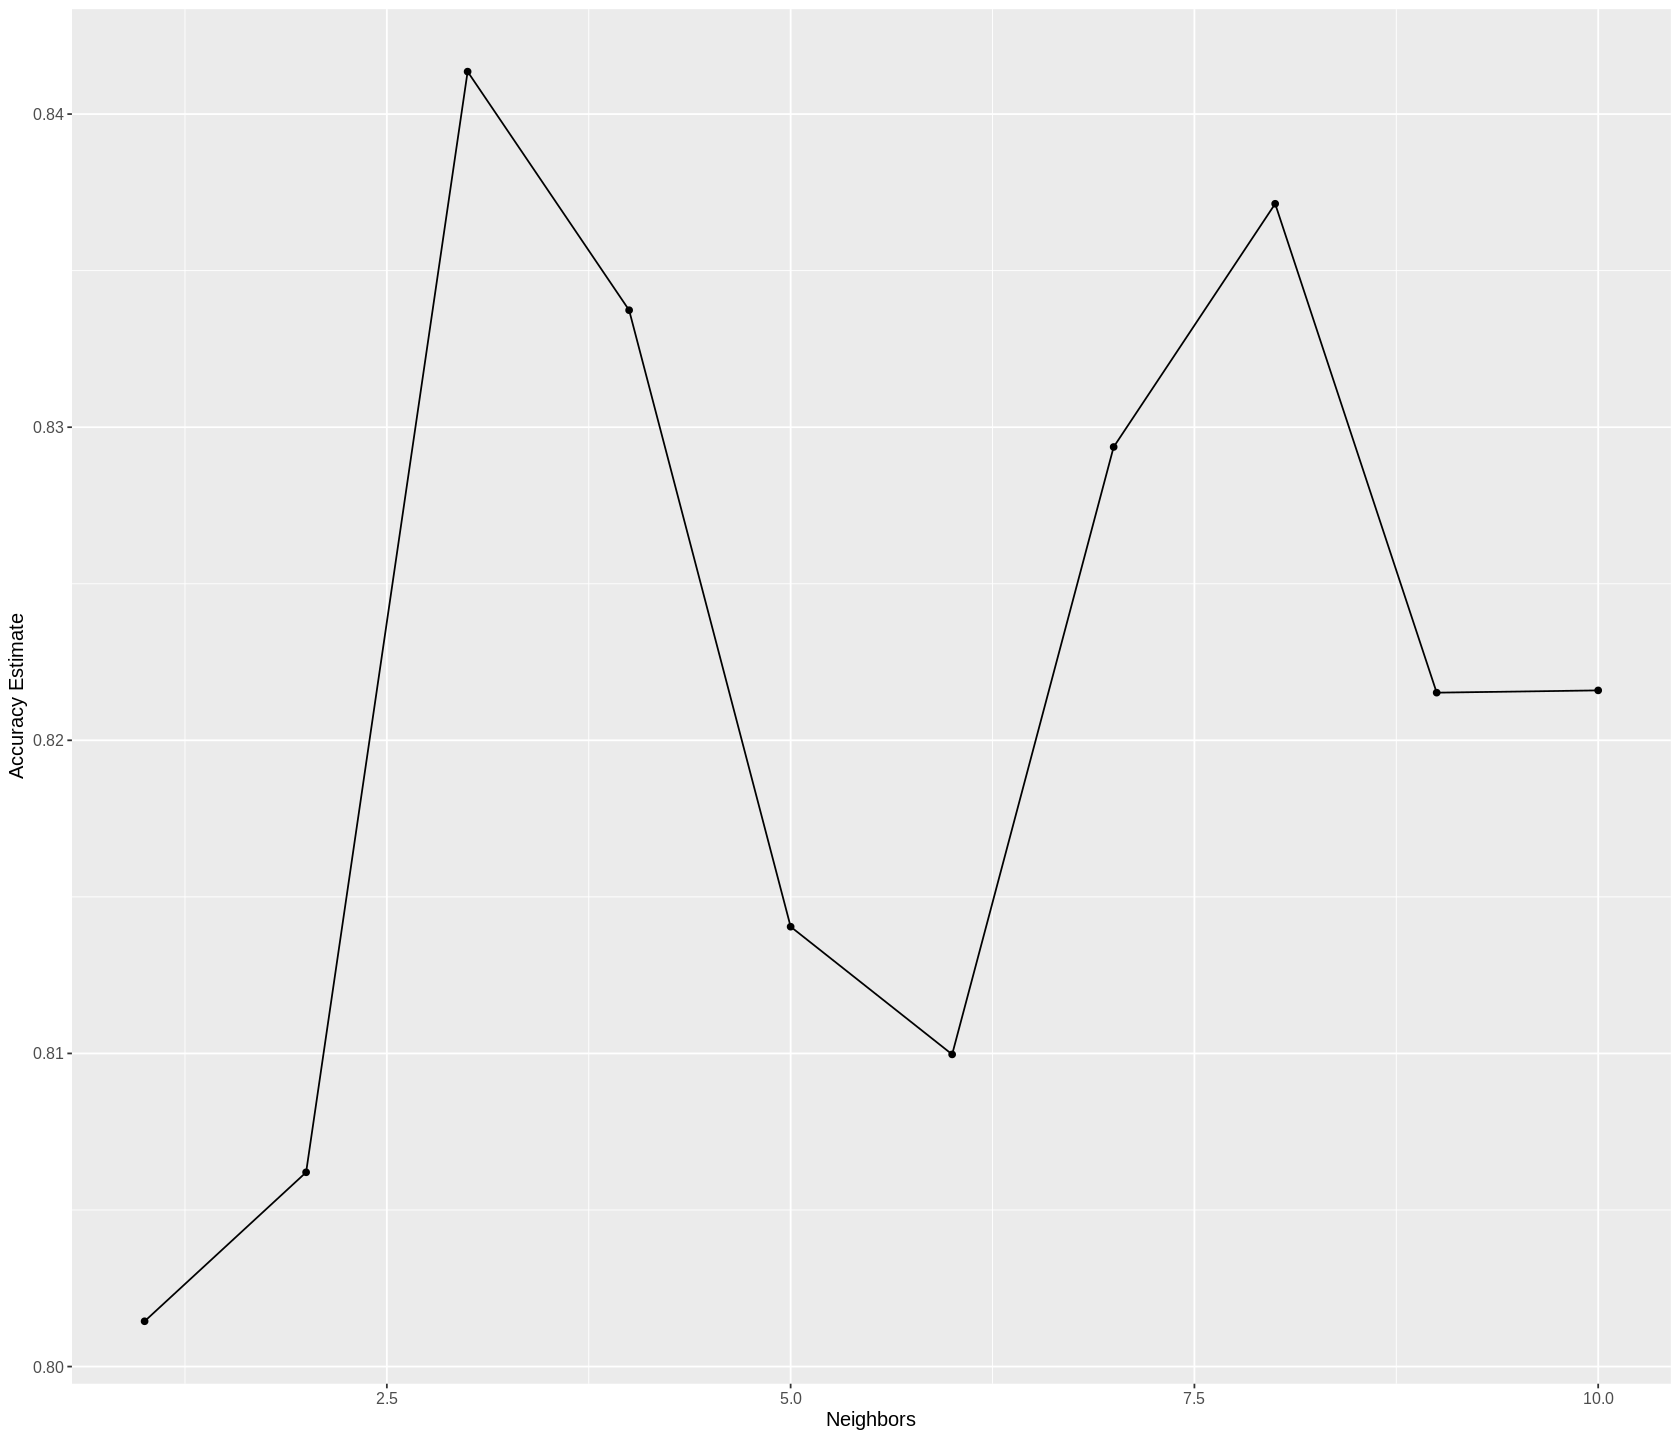

In [52]:

# data analysis with PEG as the only predictor for UNS

# set the seed
set.seed(12)

# scale & center training data
knowledge_recipe <- recipe(UNS ~ PEG, data = training_data) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

# create knn model
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# create fold
knowledge_vfold <- vfold_cv(training_data, v = 5, strata = UNS)

# specify k vals to tune
k_vals <- tibble(neighbors = seq(from = 1, to = 10))

# fit the knn model & aggregate accuracy results to a metric 
knn_results <- workflow() %>%
                  add_recipe(knowledge_recipe) %>%
                  add_model(knn_spec) %>%
				  tune_grid(resamples = knowledge_vfold, grid = k_vals) %>%
                  collect_metrics()

accuracies <- knn_results %>%
  filter(.metric == "accuracy")

# plot accuracies 
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

# determine the best K
accuracy_vs_k

# as seen from the graph, the best K is 8


In [53]:
knowledge_recipe <- recipe(UNS ~ PEG, data = training_data) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(knowledge_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = training_data)

uns_test_predictions <- predict(knn_fit, test_data) %>%
  bind_cols(test_data)

# uns_test_predictions %>%
#   metrics(truth = UNS, estimate = .pred_class) %>%
#   filter(.metric == "accuracy")


# # confusion <- cancer_test_predictions %>%
# #              conf_mat(truth = UNS, estimate = .pred_class)

uns_test_predictions

ERROR: Error in hardhat::forge(new_data, blueprint): object 'test_data' not found


In [ ]:
# data analysis with PEG and LPR as the predictors for UNS

set.seed(12)

## create a recipe
data_recipe <- recipe(UNS ~ PEG + LPR, data = training_data) %>%
               step_scale(all_predictors()) %>%
               step_center(all_predictors())

## create knn classifier
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

## perform 5-fold cross-validation
data_vfold <- vfold_cv(training_data, v = 5, strata = UNS)

## create a tune_grid
k_vals <- tibble(neighbors = seq(from = 1, to = 10))

## get the results
data_results <- workflow() %>%
                add_recipe(data_recipe) %>%
                add_model(knn_spec) %>%
                tune_grid(resamples = data_vfold, grid = k_vals) %>%
                collect_metrics()

## filter accuracy
accuracies <- data_results %>%
              filter(.metric == "accuracy")

## plot the accuracy versus k
accuracy_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                 geom_point() +
                 geom_line() +
                 labs(x = "Neighbors", y = "Accuracy Estimation") +
                 theme(text = element_text(size = 20))
accuracy_plot

In [ ]:
## create the new knn classifier
new_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
                set_engine("kknn") %>%
                set_mode("classification")

## create a new wokflow
knn_fit <- workflow() %>%
           add_recipe(data_recipe) %>%
           add_model(new_knn_spec) %>%
           fit(data = training_data)

## predict the test data
testing_data_predictions <- predict(knn_fit, test_data) %>%
                            bind_cols(test_data)
testing_data_predictions

## check the accuracy
test_prediction <- testing_data_predictions %>% 
                   metrics(truth = UNS, estimate = .pred_class)
test_prediction
## check the confusion matrix
test_confusion <- test_prediction %>%
                  conf_mat(truth = UNS, estimate = .pred_class)

## Citation
Dua, D. and Graff, C. (2019). <a href="http://archive.ics.uci.edu/ml" target="_blank">UCI Machine Learning Repository</a>. Irvine, CA: University of California, School of Information and Computer Science.

H. T. Kahraman, Sagiroglu, S., Colak, I., Developing intuitive knowledge classifier and modeling of users' domain dependent data in web, Knowledge Based Systems, vol. 37, pp. 283-295, 2013.